In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Enter The method of inpainting FMM(1) or Partial Convolutions(2)2


1/1 [==============================] - 1s 617ms/step


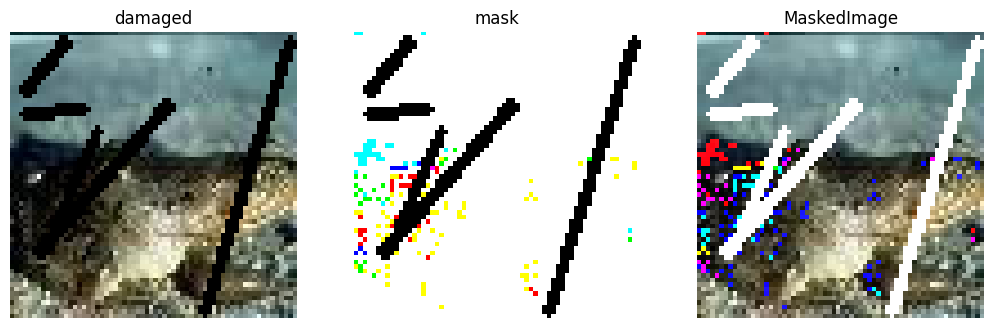

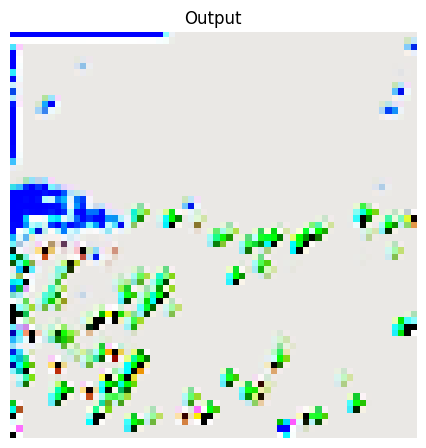

In [29]:

"""Untitled3.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1JDT20VaAC__TXf_58aiH7dBK2o9smvYq
"""
import cv2
import numpy as np
import matplotlib.pyplot as plt
import cv2

image = cv2.imread('/content/drive/MyDrive/PCONV_INPUT_IMAGE.jpg')
h=image.shape[0]
w=image.shape[1]
num_lines = 5
mask =np.ones((h, w, 3), dtype=np.uint8) * 255
plt.figure(figsize=(17, 8))

for _ in range(num_lines):
    start_point = (random.randint(0,w-1), random.randint(0,h-1))
    end_point = (random.randint(0, w-1), random.randint(0, h-1))
    color = (0, 0, 0)
    thickness = 2
    cv2.line(image, start_point, end_point, color, thickness)


plt.subplot(1, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("damaged")
plt.axis('off')

for i in range(w):
  for j in range(h):
    for z in range(3):
     if image[i,j,z] == 0:
      mask[i,j,z]=0
      image[i,j,z]=255
plt.subplot(1, 4, 2)
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
plt.title("mask")
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("MaskedImage")
plt.axis('off')
from tensorflow.keras import backend as K
from tensorflow.keras.layers import InputSpec
from tensorflow.keras.layers import Conv2D
import cv2
from tensorflow.keras.utils import get_custom_objects
import matplotlib.pyplot as plt
import math
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt

class PConv2D(Conv2D):
    def __init__(self, *args, n_channels=3, mono=False, **kwargs):
        super().__init__(*args, **kwargs)
        self.input_spec = [InputSpec(ndim=4), InputSpec(ndim=4)]

    def build(self, input_shape):
        """Adapted from original _Conv() layer of Keras
        param input_shape: list of dimensions for [img, mask]
        """

        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1

        if input_shape[0][channel_axis] is None:
            raise ValueError('The channel dimension of the inputs should be defined. Found `None`.')

        self.input_dim = input_shape[0][channel_axis]

        # Image kernel
        kernel_shape = self.kernel_size + (self.input_dim, self.filters)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='img_kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        # Mask kernel
        self.kernel_mask = K.ones(shape=self.kernel_size + (self.input_dim, self.filters))

        # Calculate padding size to achieve zero-padding
        self.pconv_padding = (
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)),
            (int((self.kernel_size[0]-1)/2), int((self.kernel_size[0]-1)/2)),
        )

        # Window size - used for normalization
        self.window_size = self.kernel_size[0] * self.kernel_size[1]

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs, mask=None):
        '''
        We will be using the Keras conv2d method, and essentially we have
        to do here is multiply the mask with the input X, before we apply the
        convolutions. For the mask itself, we apply convolutions with all weights
        set to 1.
        Subsequently, we clip mask values to between 0 and 1
        '''

        # Both image and mask must be supplied
        if type(inputs) is not list or len(inputs) != 2:
            raise Exception('PartialConvolution2D must be called on a list of two tensors [img, mask]. Instead got: ' + str(inputs))

        # Padding done explicitly so that padding becomes part of the masked partial convolution
        images = K.spatial_2d_padding(inputs[0], self.pconv_padding, self.data_format)
        masks = K.spatial_2d_padding(inputs[1], self.pconv_padding, self.data_format)

        # Apply convolutions to mask
        mask_output = K.conv2d(
            masks, self.kernel_mask,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Apply convolutions to image
        img_output = K.conv2d(
            (images*masks), self.kernel,
            strides=self.strides,
            padding='valid',
            data_format=self.data_format,
            dilation_rate=self.dilation_rate
        )

        # Calculate the mask ratio on each pixel in the output mask
        mask_ratio = self.window_size / (mask_output + 1e-8)

        # Clip output to be between 0 and 1
        mask_output = K.clip(mask_output, 0, 1)

        # Remove ratio values where there are holes
        mask_ratio = mask_ratio * mask_output

        # Normalize iamge output
        img_output = img_output * mask_ratio

        # Apply bias only to the image (if chosen to do so)
        if self.use_bias:
            img_output = K.bias_add(
                img_output,
                self.bias,
                data_format=self.data_format)

        # Apply activations on the image
        if self.activation is not None:
            img_output = self.activation(img_output)

        return [img_output, mask_output]

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            space = input_shape[0][1:-1]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0][0],) + tuple(new_space) + (self.filters,)
            return [new_shape, new_shape]
        if self.data_format == 'channels_first':
            space = input_shape[2:]
            new_space = []
            for i in range(len(space)):
                new_dim = conv_output_length(
                    space[i],
                    self.kernel_size[i],
                    padding='same',
                    stride=self.strides[i],
                    dilation=self.dilation_rate[i])
                new_space.append(new_dim)
            new_shape = (input_shape[0], self.filters) + tuple(new_space)
            return [new_shape, new_shape]

## Reference: https://github.com/keras-team/keras/blob/7a39b6c62d43c25472b2c2476bd2a8983ae4f682/keras/utils/conv_utils.py#L85
def conv_output_length(input_length, filter_size,
                       padding, stride, dilation=1):
    """Determines output length of a convolution given input length.
    # Arguments
        input_length: integer.
        filter_size: integer.
        padding: one of `"same"`, `"valid"`, `"full"`.
        stride: integer.
        dilation: dilation rate, integer.
    # Returns
        The output length (integer).
    """
    if input_length is None:
        return None
    assert padding in {'same', 'valid', 'full', 'causal'}
    dilated_filter_size = (filter_size - 1) * dilation + 1
    if padding == 'same':
        output_length = input_length
    elif padding == 'valid':
        output_length = input_length - dilated_filter_size + 1
    elif padding == 'causal':
        output_length = input_length
    elif padding == 'full':
        output_length = input_length + dilated_filter_size - 1
    return (output_length + stride - 1) // stride

def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))


#image_path=input("Enter Image path in the following format : ")
#image=cv2.imread(image_path)
#mask_path=input("Enter mask path in the following format : ")
#mask=cv2.imread(mask_path)


op=int(input('Enter The method of inpainting FMM(1) or Partial Convolutions(2)'))

if op==1:


  KNOWN = 0
  BAND = 1
  INSIDE = 2
  EPS = 1e-6

  def solve(i1, j1, i2, j2,T,f):
      MAX_VALUE = 1000000
      sol = MAX_VALUE

      if i1 < 0 or i1 >= T.shape[0] or j1 < 0 or j1 >= T.shape[1]:
          return sol

      if i2 < 0 or i2 >= T.shape[0] or j2 < 0 or j2 >= T.shape[1]:
          return sol

      flag1 = f[i1, j1]
      flag2 = f[i2, j2]


      if flag1 == KNOWN and flag2 == KNOWN:
          T1 = T[i1, j1]
          T2 = T[i2, j2]
          d = 2.0 - (T1 - T2) ** 2
          if d > 0.0:
              r = math.sqrt(d)
              s = (T1 + T2 - r) / 2.0
              if s >= T1 and s >= T2:
                  return s
              else:
                  s += r
                  if s <= T1 and s <= T2:
                      return s


      if flag1 == KNOWN:
          T1 = T[i1, j1]
          return 1.0 + T1
      elif flag2 == KNOWN:
          T2 = T[i2, j2]
          return 1.0 + T2


      return sol


  def inpaint(i, j, T, image):
      b=1

      Be = [(i - b, j), (i + b, j), (i, j - b), (i, j + b)]
      grad_T = np.gradient(T)
      gradI = np.array([0, 0])


      for z in range(3):
          Ia = 0
          s = 0
          for x in Be:
              if 0 <= x[0] < image.shape[0] and 0 <= x[1] < image.shape[1] and f[x[0],x[1]]==KNOWN :
                  r = np.array([x[0] - i, x[1] - j])
                  dot_gradt_r = (grad_T[0][i, j] * r[0]) + (grad_T[1][i, j] * r[1])
                  dir = dot_gradt_r / (np.linalg.norm(r, 1))
                  if dir==0:
                    dir=EPS
                  dst = 1 / (np.linalg.norm(r, 1) ** 2)
                  lev = 1 / (1 + np.abs(T[x[0], x[1]] - T[i, j]))
                  w = (dir * dst * lev)

                  if (0 <= x[0] + 1 < image.shape[0] and 0 <= x[1] + 1 < image.shape[1] and 0 <= x[0] - 1 and x[1] - 1 >= 0):
                      gradI = np.array([image[x[0] + 1, x[1], z] - image[x[0] - 1, x[1], z], image[x[0], x[1] + 1, z] - image[x[0], x[1] - 1, z]])
                  dot_gradi_r = (gradI[0] * r[0]) + (gradI[1] * r[1])
                  Ia += w * (image[x[0], x[1], z] + dot_gradi_r)
                  s += w
          if s!=0:
            image[i, j, z] = Ia / s
          else:
            image[i, j, z] = 0
      return image






  for i in range(0,image.shape[0]):
   for j in range(0,image.shape[1]):
    for k in range(0,3):
      if mask[i,j,k]==0:
        image[i,j,k]=0



  cv2.imshow('',image)

  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  T = np.zeros_like(gray_image)
  narrow_band = []
  f = np.zeros_like(gray_image)

  for i in range(0, gray_image.shape[0]):
      for j in range(0, gray_image.shape[1]):
         if gray_image[i, j] != 0:
          T[i, j] = 0
          f[i,j] = KNOWN
          if gray_image[min(i+1,gray_image.shape[0]-1), j]== 0 or gray_image[max(i-1,0), j]== 0 or gray_image[i,min(j+1,gray_image.shape[0]-1)]==0 or gray_image[i ,max(j-1,0)]==0:
              f[i,j]=BAND
              narrow_band.append([i, j])
         else:
              T[i, j] =1000000
              f[i,j]=INSIDE
  print(narrow_band)
  for iteration in range(50):

    while narrow_band:
        min_distance = 1000000
        min_point = None

        for point in narrow_band:
            if T[point[0], point[1]] < min_distance:
                min_distance = T[point[0], point[1]]
                min_point = point

        current_point = min_point

        if current_point is None:
            break
        f[current_point[0],current_point[1]]=KNOWN
        narrow_band.remove(current_point)

        neighbors = [(current_point[0] - 1, current_point[1]),(current_point[0] + 1, current_point[1]),(current_point[0], current_point[1] - 1),(current_point[0], current_point[1] + 1)]

        for neighbor in neighbors:
          if 0 <= neighbor[0] < image.shape[0] and 0 <= neighbor[1] < image.shape[1]:
            if f[neighbor[0],neighbor[1]]!=KNOWN:
              if f[neighbor[0],neighbor[1]]==INSIDE:
                f[neighbor[0],neighbor[1]]=BAND
                b=10
                inpaint(neighbor[0],neighbor[1],T,image)


              T[neighbor[0],neighbor[1]]=min(solve(neighbor[0]-1,neighbor[1],neighbor[0],neighbor[1]-1,T,f),solve(neighbor[0]+1,neighbor[1],neighbor[0],neighbor[1]-1,T,f),solve(neighbor[0]-1,neighbor[1],neighbor[0],neighbor[1]+1,T,f),solve(neighbor[0]+1,neighbor[1],neighbor[0],neighbor[1]+1,T,f))
              narrow_band.append(neighbor)

  kernel_size = 5


  blurred_image = cv2.medianBlur(image, kernel_size)

  d = 9
  sigma_color = 75
  sigma_space = 75


  filtered_image = cv2.bilateralFilter(blurred_image, d, sigma_color, sigma_space)

  cv2.imshow('',filtered_image)

elif op==2 :




  input_image, input_mask = image,mask


  input_image = np.expand_dims(input_image, axis=0)
  input_mask = np.expand_dims(input_mask, axis=0)
  get_custom_objects().update({'PConv2D': PConv2D, 'dice_coef': dice_coef})
  # Load your model
  model = load_model('/content/drive/MyDrive/trainedmodel (1).h5')


  # Run the model to predict the inpainted image
  predicted_image = model.predict([input_image, input_mask])

# Post-process the output
  output_image = predicted_image.squeeze()
  output_image = (output_image * 255).astype(np.uint8)

  plt.figure(figsize=(17, 8))

# Plot the output image
  plt.subplot(1, 4, 4)
  plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
  plt.title("Output")
  plt.axis('off')

# Display the plots
  plt.tight_layout()
  plt.show()